$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge NVSS$ $\hspace{0.1cm}$ $\Huge point$ $\hspace{0.1cm}$ $\Huge sources$ $\hspace{0.1cm}$ $\Huge :$ 

# Module : 

In [1]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
import numpy as np
from astropy import constants as cst
from astropy.cosmology import FlatLambdaCDM
import pysm as pysm
import ccatp_sky_model as sky
from tqdm import tqdm 
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [3]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Function : 

In [10]:
def simulate_nvss_ps(freq, nside_out = 4096, beam_FWHM = None, unit = 'cmb'):

    '''Computes a map that contains all ~1,800,000 point sources from the NVSS PS catalog 
    (Condon et al. 1998). The measured 1.4 GHz fluxes are extrapolated to the mm/sub-mm 
    regime my assigning each source a random spectral index drawn from N(-0.5, 0.1). This 
    function is not part of the default CCAT-p sky model and serves only for allow to 
    reproduce the forecast results obtained with previous sky models  
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz. Must be a valid SO or CCAT-prime central
        band frequency, i.e. 27, 39, 93, 145, 225, 279, 220, 280, 350, 405, or 860 GHz.
    nside_out: float, optional
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096    
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
    Returns
    -------
    ps_model: float array
        Healpix all-sky map containing the NVSS point sources.
    '''

    if beam_FWHM is None:
        print('Warning: beam is not allowed to be None or 0. beam_FWHM will be set to 1 arcmin')
        beam_FWHM = 1

    #read data
    data = ascii.read(data_path + 'catalogs/NVSS_ps_results.txt')
    RA = np.array(data['RA'])
    DEC = np.array(data['DEC'])
    flux = np.array(data['flux@1.4GHz'])
    alpha = np.array(data['alpha'])
    n = len(RA)

    #compute spectra
    flux = flux*(freq/1.4e9)**(alpha)
    sigma = beam_FWHM/60*np.pi/180 / (2*np.sqrt(2*np.log(2)))
    amplitude_ps = flux / (2*np.pi*sigma**2) / 1e6

    #compute positions
    coord = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree, frame='fk5')

    gl = coord.galactic.l.value
    gb = coord.galactic.b.value

    phi = gl * np.pi/180.
    theta = (90-gb) * np.pi/180.

    vector = hp.pixelfunc.ang2vec(theta, phi)

    #build map
    ps_model = np.zeros(hp.pixelfunc.nside2npix(nside_out), dtype=np.float32)
    for i in tqdm(np.arange(n)):
        if amplitude_ps[i] > 0:
            index = hp.query_disc(nside_out, vector[i,:], 5*sigma, inclusive = True)
            vec = hp.pixelfunc.pix2vec(nside_out, index)
            distances = hp.rotator.angdist(vector[i,:], vec)
            ps_model[index] += amplitude_ps[i]*np.exp(-0.5*(distances**2/sigma**2))

    #Convert units if necessary
    if unit == 'cmb':
        ps_model = sky.convert_units(freq, ps_model, mjy2cmb=True)
    elif unit == 'mjy':
        None
    elif unit == 'rj':
        ps_model = sky.convert_units(freq, ps_model, mjy2rj=True)
    else:
        ps_model = sky.convert_units(freq, ps_model, mjy2cmb=True)
        print('Waring: Unknown unit! Output will be in K_CMB')
		   
    return(ps_model)

# Launch : 

In [11]:
map_NVSS = simulate_nvss_ps(freq=350e9, nside_out = 1024, beam_FWHM = 1, unit = 'cmb')

100%|██████████| 1773484/1773484 [13:53<00:00, 2127.21it/s]


masked_array(
  data=[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],
  mask=False,
  fill_value=-1.6375e+30)

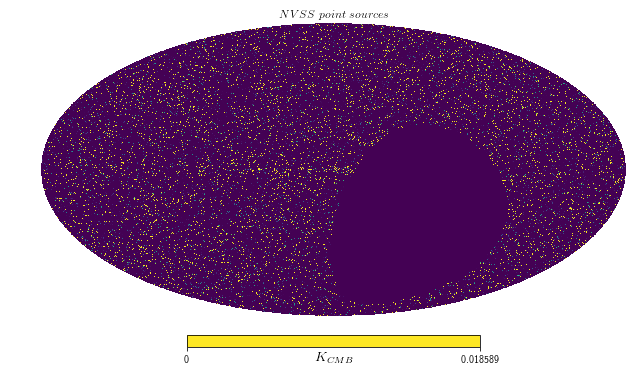

In [12]:
hp.mollview(map=map_NVSS, coord=None, nest=False, title='$NVSS$ $point$ $sources$',
            unit='$K_{CMB}$', norm='hist', xsize=2000,return_projected_map=True)